# Actividad para minimizar el impacto del sobre-ajuste.

## Etapa 1: Definición de los datos.

Antes de comenzar definimos la base de datos de interés. Usaremos la base de datos IMBD que consiste en reseñas hechas a 25000 películas. La tarea que configura esta base de datos consiste en predecir si el comentario es positivo o negativo. ([Ver enlace](https://keras.io/api/datasets/imdb/))

In [2]:
!pip install keras-tuner --upgrade

Se cargan las librerías necesarias

In [3]:
from keras.datasets import imdb
import tensorflow as tf
import numpy as np
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from keras_tuner import RandomSearch

Se carga la base de datos

In [4]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

Se definen funciones para la visualización de la función de costo

In [5]:
def evaluate(model, history):
    # Se evalúa el accuracy del modelo tanto en el conjunto de entrenamiento como
    # en el de prueba.
    _, train_accuracy = model.evaluate(x_train, y_train)
    _, test_accuracy = model.evaluate(x_test, y_test)

    print(f"Trainining accuracy: {train_accuracy:.2f}")
    print(f"Testing accuracy: {test_accuracy:.2f}")

    # Se grafica la función de costo para los conjuntos de entrenamiento y
    # prueba.
    plt.figure(figsize=(4, 3), dpi=160)

    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend()
    plt.show()

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [6]:
# Procesamiento de los datos.
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [7]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [8]:
# Se definen los conjuntos de entrenamiento y prueba
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [9]:
# Se define la red neuronal.

model = models.Sequential([
  layers.Dense(16, activation='relu', input_shape=(10000,)),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
  ])

In [10]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Epoch 1/50
30/30 [==============================] - 7s 71ms/step - loss: 0.5446 - accuracy: 0.7630 - val_loss: 0.4180 - val_accuracy: 0.8607
Epoch 2/50
30/30 [==============================] - 1s 23ms/step - loss: 0.3419 - accuracy: 0.8902 - val_loss: 0.3568 - val_accuracy: 0.8574
Epoch 3/50
30/30 [==============================] - 1s 24ms/step - loss: 0.2547 - accuracy: 0.9176 - val_loss: 0.2934 - val_accuracy: 0.8873
Epoch 4/50
30/30 [==============================] - 1s 41ms/step - loss: 0.2048 - accuracy: 0.9323 - val_loss: 0.2770 - val_accuracy: 0.8892
Epoch 5/50
30/30 [==============================] - 1s 41ms/step - loss: 0.1684 - accuracy: 0.9440 - val_loss: 0.2762 - val_accuracy: 0.8886
Epoch 6/50
30/30 [==============================] - 1s 24ms/step - loss: 0.1428 - accuracy: 0.9552 - val_loss: 0.2998 - val_accuracy: 0.8831
Epoch 7/50
30/30 [==============================] - 1s 24ms/step - loss: 0.1220 - accuracy: 0.9629 - val_loss: 0.2927 - val_accuracy: 0.8845
Epoch 8/50
30

busqueda de hiperparametros



In [12]:
# Número de épocas para los experimentos
epochs = 10

In [13]:
def build_model_1(hp):
  model = Sequential()
  for i in range(hp.Int('num_layers', 1, 3, 1)): # range(2)
    model.add(Dense(units = hp.Choice('units'+str(i+1), [16, 32,64]), activation = hp.Choice('activation'+str(i+1), ['relu', 'sigmoid','tanh'])))
  model.add(Dense(10, activation = 'softmax'))
  optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.001,0.0001]))
  model.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [14]:
tuner = RandomSearch(build_model_1, objective = 'val_loss', max_trials = 10)
tuner.search(x_train, y_train, epochs = epochs, validation_data = (x_val, y_val), verbose=2, callbacks=[tf.keras.callbacks.TensorBoard('my_dir')])
best_model = tuner.get_best_models()[0]

Reloading Tuner from ./untitled_project/tuner0.json


In [15]:
best_model = tuner.get_best_models()[0]

In [16]:
print(best_model.layers[0].units,best_model.layers[1])
print(best_model.layers[0].activation, best_model.layers[1].activation)
print(best_model.optimizer.learning_rate)

32 <keras.src.layers.core.dense.Dense object at 0x7f2a2e1f00d0>
<function relu at 0x7f2a38afe9e0> <function softmax at 0x7f2a38afdfc0>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


In [17]:
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

782/782 [==============================] - 4s 4ms/step - loss: 0.8492 - accuracy: 0.8582
test_acc: 0.8582000136375427


In [18]:
tuner.get_best_models()

In [19]:
history_1 = best_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/50
30/30 [==============================] - 5s 122ms/step - loss: 9.1215e-04 - accuracy: 1.0000 - val_loss: 9.8709e-04 - val_accuracy: 1.0000
Epoch 2/50
30/30 [==============================] - 1s 45ms/step - loss: 8.4683e-04 - accuracy: 1.0000 - val_loss: 9.7732e-04 - val_accuracy: 1.0000
Epoch 3/50
30/30 [==============================] - 1s 47ms/step - loss: 7.9205e-04 - accuracy: 1.0000 - val_loss: 9.8438e-04 - val_accuracy: 1.0000
Epoch 4/50
30/30 [==============================] - 1s 38ms/step - loss: 7.2687e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 5/50
30/30 [==============================] - 1s 21ms/step - loss: 6.5800e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/50
30/30 [==============================] - 1s 20ms/step - loss: 5.8958e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/50
30/30 [==============================] - 1s 24ms/step - loss: 5.3225e-04 - accuracy: 1.0000 - val_loss: 0.

In [20]:
def evaluate(best_model, history_1):
    # Se evalúa el accuracy del modelo tanto en el conjunto de entrenamiento como
    # en el de prueba.
    _, train_accuracy = best_model.evaluate(x_train, y_train)
    _, test_accuracy = best_model.evaluate(x_test, y_test)

    print(f"Trainining accuracy: {train_accuracy:.2f}")
    print(f"Testing accuracy: {test_accuracy:.2f}")

    # Se grafica la función de costo para los conjuntos de entrenamiento y
    # prueba.
    plt.figure(figsize=(4, 3), dpi=160)

    plt.plot(history_1.history["loss"], label="train")
    plt.plot(history_1.history["val_loss"], label="test")
    plt.legend()
    plt.show()

782/782 [==============================] - 2s 2ms/step - loss: 1.0158 - accuracy: 0.8601
Trainining accuracy: 1.00
Testing accuracy: 0.86


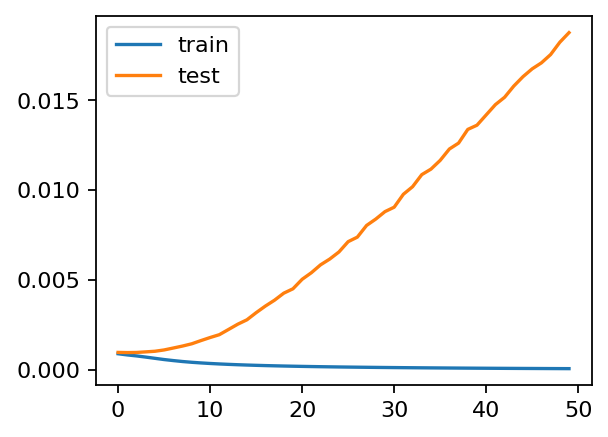

In [21]:
evaluate(best_model, history_1)